# How to access to the DATASET ? 

In [32]:
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np

# Dataset Information:
# All images of 512 x 512
# X : Tomography - image reconstructed - already normalized (0-1)
# y : Mask - unique values (0: background - 1: kidney - 2: tumor - 3: cyst)

# LABEL_AGGREGATION_ORDER = (1, 3, 2) The order matters!
# This means that we first place the kidney, then the cyst and finally the tumor.
# If parts of a later label (example tumor) overlap with a prior label (kidney or cyst) the prior label is overwritten.
#
# KITS_LABEL_NAMES = {
#     1: "kidney",
#     2: "tumor",
#     3: "cyst"
# }

class TomographyDataset(Dataset):  
    
    def __init__(self, data_dir = './data/', dataset_csv = './data/dataset.csv', split_set ='train'):
        super(Dataset, self).__init__()
        self.data_dir = data_dir
        self.dataset_df = pd.read_csv(dataset_csv)
        self.split_set = split_set

        if self.split_set == 'train':
            self.dataset_df = self.dataset_df[self.dataset_df['split_set'] == 'train']

        elif self.split_set == 'validation':
            self.dataset_df = self.dataset_df[self.dataset_df['split_set'] == 'validation']
        
        elif self.split_set == 'test':
            self.dataset_df = self.dataset_df[self.dataset_df['split_set'] == 'test']
        
        self.dataset_df.reset_index(inplace=True, drop=True)

    
    def __getitem__(self, index):
        X_path = self.dataset_df['reconstruction_file'][index]
        y_path = self.dataset_df['mask_file'][index]

        X_img = np.load(self.data_dir + X_path)

        # condition to create an image if it does not exist
        try:
            y_img = np.load(self.data_dir + y_path)
        except:
            y_img = np.zeros(shape = (512,512))

        y_img4 = self.one_hot_encoding(y_img)
        y_img4 = np.append(y_img4, y_img.reshape(1,512,512), axis=0)

        item = X_img, y_img4
        
        return item
    
    def __len__(self): 
        return self.dataset_df.shape[0] 
    
    @staticmethod
    def one_hot_encoding(mask_img, shape = (4,512,512)):
        ohe = np.zeros(shape = shape)
        for i in range(shape[1]):
            for j in range(shape[2]):
                label = mask_img[i,j]
                if label == 0:
                    ohe[:,i,j] = [1,0,0,0] # background, kidney, tumor, cyst
                elif label == 1: 
                    ohe[:,i,j] = [0,1,0,0]
                elif label == 2:
                    ohe[:,i,j] = [0,1,1,0]
                elif label == 2:
                    ohe[:,i,j] = [0,1,0,1]

        return ohe # 4 channels 
    
    @staticmethod
    def show_item(X, y_img4):
        fig, ax = plt.subplots(ncols=6, figsize=(20,10))
        ax=ax.reshape(-1)
        ax[0].imshow(X, cmap='Greys')
        ax[1].imshow(y_img4[0], cmap='Greys', vmin = 0, vmax = 1) # background
        ax[2].imshow(y_img4[1], cmap='Greys', vmin = 0, vmax = 1) # kidney
        ax[3].imshow(y_img4[2], cmap='Greys', vmin = 0, vmax = 1) # tumor
        ax[4].imshow(y_img4[3], cmap='Greys', vmin = 0, vmax = 1) # cyst
        ax[5].imshow(y_img4[4]) # mask

        


In [33]:
my_train = TomographyDataset(split_set ='train')
my_val = TomographyDataset(split_set ='validation')
my_test = TomographyDataset(split_set ='test')

print(my_train.__len__()) 
print(my_val.__len__()) 
print(my_test.__len__()) 

my_val.dataset_df.head()

1316
184
1517


,Unnamed: 0,patient_idx,number_of_slice,niigz_file_location,split_set,mu_water,photons_per_pixel,source_to_axis,det_to_axis,det_spacing,...,object_size,slice_index,is_mask,slice_min_value,slice_max_value,image_file,sinogram_normalization_factor,sinogram_file,reconstruction_file,mask_file
0,51720,61,29,case_00061/imaging.nii.gz,validation,0.02,10000.0,1000,500,0.9,...,256,0,False,-2048.0,919.0,normalized/case_00061_0.png,5.12,sinogram/case_00061_0.npy,reconstruction/case_00061_0.npy,mask/case_00061_0.npy
1,51721,61,29,case_00061/imaging.nii.gz,validation,0.02,10000.0,1000,500,0.9,...,256,1,False,-2048.0,998.0,normalized/case_00061_1.png,5.12,sinogram/case_00061_1.npy,reconstruction/case_00061_1.npy,mask/case_00061_1.npy
2,51722,61,29,case_00061/imaging.nii.gz,validation,0.02,10000.0,1000,500,0.9,...,256,2,True,-2048.0,1023.0,normalized/case_00061_2.png,5.12,sinogram/case_00061_2.npy,reconstruction/case_00061_2.npy,mask/case_00061_2.npy
3,51723,61,29,case_00061/imaging.nii.gz,validation,0.02,10000.0,1000,500,0.9,...,256,3,True,-2048.0,1033.0,normalized/case_00061_3.png,5.12,sinogram/case_00061_3.npy,reconstruction/case_00061_3.npy,mask/case_00061_3.npy
4,51724,61,29,case_00061/imaging.nii.gz,validation,0.02,10000.0,1000,500,0.9,...,256,4,True,-2048.0,1094.0,normalized/case_00061_4.png,5.12,sinogram/case_00061_4.npy,reconstruction/case_00061_4.npy,mask/case_00061_4.npy


# No kidney, tumor or cyst found

[1.]
[0.]
[0.]
[0.]
[0.]


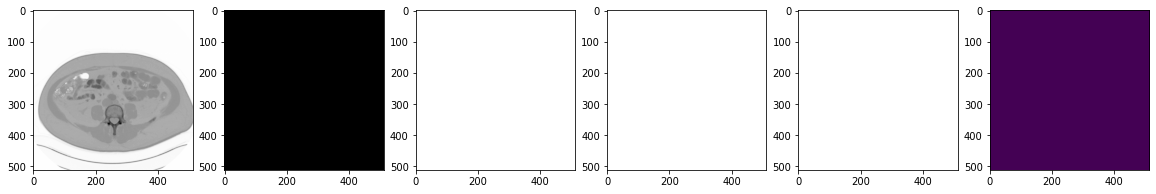

In [6]:
i = 219
y = np.zeros(shape = (5,512,512))
X = y 
while (np.unique(y[0]) != [1.]).any():
    X, y = myds.__getitem__(i) # show reconstruction, mask, superposed (reco + mask)
    i += 1

myds.show_item(X,y)

print(np.unique(y[0]))
print(np.unique(y[1]))
print(np.unique(y[2]))
print(np.unique(y[3]))
print(np.unique(y[4]))


[0. 1.]
[0. 1.]
[0. 1.]
[0.]
[0. 1. 2.]


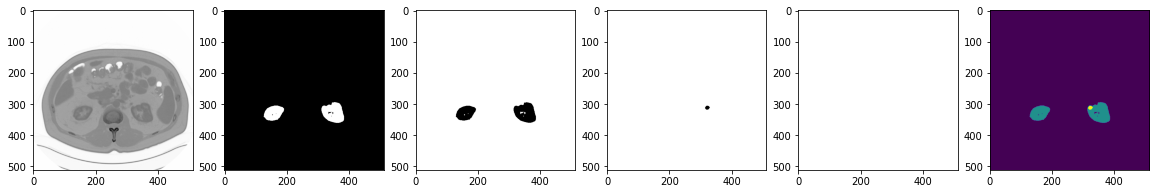

In [7]:
X,y = myds.__getitem__(200)
myds.show_item(X,y)

print(np.unique(y[0]))
print(np.unique(y[1]))
print(np.unique(y[2]))
print(np.unique(y[3]))
print(np.unique(y[4]))

# Create Dataloader

In [66]:
from torch.utils.data import DataLoader

def create_loader(dataset, batch_size = 3, shuffle = True):
    dataloader = DataLoader(dataset =dataset, 
                            batch_size=batch_size,
                            shuffle = shuffle
                            )
    return dataloader

In [67]:
dataloader  = create_loader(myds)
dataiter    = iter(dataloader)
data        = dataiter.next()
X, y = data

next(iter(dataloader))

[tensor([[[0.0000e+00, 5.2090e-03, 8.1214e-03,  ..., 3.6058e-03,
           5.4328e-03, 0.0000e+00],
          [4.5285e-03, 7.6784e-03, 9.3847e-03,  ..., 7.0721e-03,
           9.8869e-03, 5.4408e-03],
          [5.4180e-03, 5.7347e-03, 4.8443e-03,  ..., 7.7653e-03,
           9.3266e-03, 5.9716e-03],
          ...,
          [7.6542e-03, 9.0274e-03, 9.5426e-03,  ..., 9.3925e-03,
           1.4439e-02, 1.1312e-02],
          [4.7187e-03, 9.0472e-03, 7.8592e-03,  ..., 7.2104e-03,
           9.5485e-03, 8.7647e-03],
          [0.0000e+00, 5.3043e-03, 5.1991e-03,  ..., 4.1950e-03,
           1.4953e-03, 0.0000e+00]],
 
         [[5.6006e-03, 5.0222e-03, 3.2340e-03,  ..., 5.6597e-03,
           3.1577e-03, 4.2761e-03],
          [2.4435e-03, 6.8439e-03, 4.8896e-03,  ..., 2.4934e-03,
           1.8098e-03, 9.0791e-04],
          [0.0000e+00, 1.9439e-03, 4.0124e-03,  ..., 1.8896e-04,
           0.0000e+00, 4.9689e-03],
          ...,
          [7.5070e-05, 1.4165e-03, 0.0000e+00,  ..., 0.000

In [134]:
import torch.nn as nn
import torch 

m = nn.Sigmoid()
input = torch.randn(size=(1,4,2,2))
output = m(input)

print(f'input {input}')
print(f'output {output}')

input tensor([[[[-2.0380, -0.4217],
          [ 0.6743,  2.3554]],

         [[ 0.0976, -0.0960],
          [-0.3054, -0.2442]],

         [[-2.4085, -1.8864],
          [-0.5039, -0.1638]],

         [[ 0.5578, -0.1139],
          [ 0.5794,  0.4838]]]])
output tensor([[[[0.1153, 0.3961],
          [0.6625, 0.9134]],

         [[0.5244, 0.4760],
          [0.4242, 0.4392]],

         [[0.0825, 0.1317],
          [0.3766, 0.4591]],

         [[0.6360, 0.4716],
          [0.6409, 0.6186]]]])


In [35]:
import torch
import numpy as np

y = torch.randn((2,4,3,3))
y_pred = torch.randn((2,4,3,3))

for i in range(2):
    for j in range(4):
        for k in range(3):
            for l in range(3):
                y[i,j,k,l] = 1 if y[i,j,k,l]>0 else 0 
                y_pred[i,j,k,l] = 1 if y_pred[i,j,k,l]>0 else 0  

print(y)
print("")
print(y_pred)
print("")

g =torch.sum((y * y_pred), dim=(2,3,0))/torch.sum((y + y_pred - y * y_pred), dim=(2,3,0))
g = g.cpu().detach().numpy()
h = np.around(g, 2)
print(g)
print(h/2)

tensor([[[[0., 1., 0.],
          [1., 0., 0.],
          [1., 0., 0.]],

         [[1., 1., 0.],
          [0., 0., 1.],
          [1., 0., 1.]],

         [[1., 0., 1.],
          [0., 1., 1.],
          [0., 0., 0.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 0.]]],


        [[[1., 0., 1.],
          [0., 1., 1.],
          [0., 1., 1.]],

         [[0., 1., 1.],
          [1., 1., 1.],
          [0., 0., 1.]],

         [[1., 0., 1.],
          [0., 1., 0.],
          [1., 1., 1.]],

         [[1., 1., 0.],
          [1., 0., 1.],
          [1., 1., 0.]]]])

tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 0., 0.]],

         [[1., 0., 1.],
          [1., 1., 0.],
          [1., 0., 1.]],

         [[0., 1., 1.],
          [0., 1., 1.],
          [0., 1., 0.]],

         [[1., 0., 0.],
          [0., 1., 1.],
          [0., 0., 1.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 1., 1.]],

         [[0., 1., 0.],
        

In [37]:
torch.ones(1,3)/3

tensor([[0.3333, 0.3333, 0.3333]])

In [29]:
torch.zeros(1,4)

tensor([[0., 0., 0., 0.]])